<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Report-Without-Ground-Truth-v1.0" data-toc-modified-id="Report-Without-Ground-Truth-v1.0-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Report Without Ground Truth v1.0</a></span><ul class="toc-item"><li><span><a href="#Input-prameters" data-toc-modified-id="Input-prameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Input prameters</a></span></li></ul></li><li><span><a href="#Variants-Statistics" data-toc-modified-id="Variants-Statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Variants Statistics</a></span></li><li><span><a href="#Snp-statistics" data-toc-modified-id="Snp-statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Snp statistics</a></span><ul class="toc-item"><li><span><a href="#Trinucleotide-Heatmap" data-toc-modified-id="Trinucleotide-Heatmap-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Trinucleotide Heatmap</a></span></li></ul></li><li><span><a href="#INDEL-statistics" data-toc-modified-id="INDEL-statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>INDEL statistics</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-indel-lengths" data-toc-modified-id="Distribution-of-indel-lengths-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distribution of indel lengths</a></span></li><li><span><a href="#Insertion-Deletion-Statistics-for-h-mer-indels" data-toc-modified-id="Insertion-Deletion-Statistics-for-h-mer-indels-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Insertion Deletion Statistics for h-mer indels</a></span></li></ul></li></ul></div>

# Report Without Ground Truth v1.0
## Input prameters

In [14]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser
import warnings
warnings.filterwarnings('ignore')


pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e8 else '{:,.1f}'.format(x)
pd.options.display.max_colwidth = 100

configFile='/data/deepvariants/germline/no_gt_report.config'
parser = ConfigParser()
parser.read(configFile)

no_gt_statistics_wgs = parser.get('NOGTReport', 'h5_statistics_wgs', fallback='no_gt_statistics_wgs.h5')

filtered_vcf = parser.get('NOGTReport', 'filtered_vcf',fallback='filtered_vcf.vcf.gz').split(',')
interval_list = parser.get('NOGTReport', 'interval_list')
ref_fasta = parser.get('NOGTReport', 'ref_fasta',fallback='Homo_sapiens_assembly38.fasta')
ref_fasta_dict = parser.get('NOGTReport', 'ref_fasta_dict', fallback='Homo_sapiens_assembly38.dict')

prmNames=['run_id','pipeline_version',
          'h5_statistics_wgs','filtered_vcf',
          'interval_list'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('NOGTReport', name)

h5outfile = parser.get('NOGTReport', 'h5_output', fallback='no_gt_report.h5')

prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")
prmdf

,value
run_id,017700-NA12878-Z0005-CATGTATCCTCTGAT
pipeline_version,1.5.1
h5_statistics_wgs,/data/deepvariants/germline/017700-NA12878-Z0005-CATGTATCCTCTGAT.filt.no_gt_stats_wgs.h5
filtered_vcf,/data/deepvariants/germline/017700-NA12878-Z0005-CATGTATCCTCTGAT.ann.vcf.gz
interval_list,/data/wgs_calling_regions.hg38.interval_list


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from os.path import join as pjoin
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import csv
import re

from ugvc.dna.utils import revcomp
import ugvc.vcfbed.vcftools as vcftools
import ugvc.comparison.vcf_pipeline_utils as vcf_pipeline_utils


In [16]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 26
TITLE_SIZE = 36
FIGSIZE = (16, 8)
GRID = True
COLORS = [
    "blue",
    "red",
    "green",
    "magenta",
    "black",
    "brown",
    "orange",
    "salmon",
    "teal",
    "coral",
    "lime",
    "purple",
    "cyan",
    "lavender",
    "turquoise",
    "darkgreen",
    "tan",
    "lightblue",
    "pink",
    "yellow",
    "gold",
]

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", grid=GRID)  # is grid on
plt.rc("axes", prop_cycle=plt.cycler(color=COLORS))
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=TITLE_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIGSIZE)  # size of the figure


from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")



In [17]:


def read_stat_table(no_gt_statistics_wgs, key_prefix, annotation_name):
    metric_novel = pd.read_hdf(no_gt_statistics_wgs,f'{key_prefix}_novel')
    metric_known = pd.read_hdf(no_gt_statistics_wgs,f'{key_prefix}_known')
    metric_all = pd.read_hdf(no_gt_statistics_wgs,f'{key_prefix}_all')

    metric_table = pd.concat([metric_novel, metric_known, metric_all], axis=1)
    metric_table.columns = ['novel','known','all']
    rows_to_convert_int = ['nRecords','nDeletions','nInsertions','nSnps','nIndels','nTi','nTv',
                          'nHets','nHomVar','nMultiSNPs','nMultiIndels','nBiallelicSNPs','nBiallelicIndels']
    metric_table = metric_table.astype(object)
    metric_table
    metric_table.loc[rows_to_convert_int,:] = metric_table.loc[rows_to_convert_int,:].astype(int)
    
    mi = pd.MultiIndex.from_tuples([(annotation_name, itm) for itm in list(metric_table.index)],names=['regions','metrics'])
    metric_table.set_index(mi,inplace=True)
    return metric_table
    
metric_table = read_stat_table(no_gt_statistics_wgs, 'eval', 'wgs')
metric_table_exome = read_stat_table(no_gt_statistics_wgs, 'eval_exome', 'exome')



In [18]:
import pandas as pd
from IPython.display import display,HTML

def multi_column_df_display(list_dfs, cols=2):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:1px solid !important;background-color: white'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += ((len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))


multi_column_df_display([metric_table, metric_table_exome])


<ul>
<li><b>nEvalVariants</b>- the number of variants <br></li>
<li><b>nDeletions</b>- the number of variants determined to be deletions <br></li>
<li><b>nInsertions</b>- the number of variants determined to be insertions <br></li>
<li><b>nSNPs</b>- the number of variants determined to be single-nucleotide polymorphisms <br></li>
<li><b>nTi</b>- number of transition variants (A↔G or T↔C) <br></li>
<li><b>nTv</b>- number of transversion variants (A↔T or G↔C) <br></li>
<li><b>SNP_to_indel_ratio</b>- n_SNPs divided by n_indels <br></li>
<li><b>indel_novelty_rate</b>- n_novel_indels divided by n_indels<br></li>
<li><b>insertion_to_deletion_ratio</b>- n_insertions divided by n_deletions<br></li>
<li><b>nHets</b>- the number of heterozygous loci<br></li>   
<li><b>nHomVar</b>- the number of homozygous variant loci<br></li>    
<li><b>nMultiSNPs</b>- number of multiallelic SNPs<br></li>
<li><b>nMultiIndels</b>- number of multiallelic indels<br></li>
<li><b>nBiallelicSNPs</b>- nSNPs minus nMultiSNPs<br></li>
<li><b>nBiallelicIndels</b>- nIndels minus nMultiIndels<br></li>
</ul>





# INDEL statistics

## Distribution of indel lengths

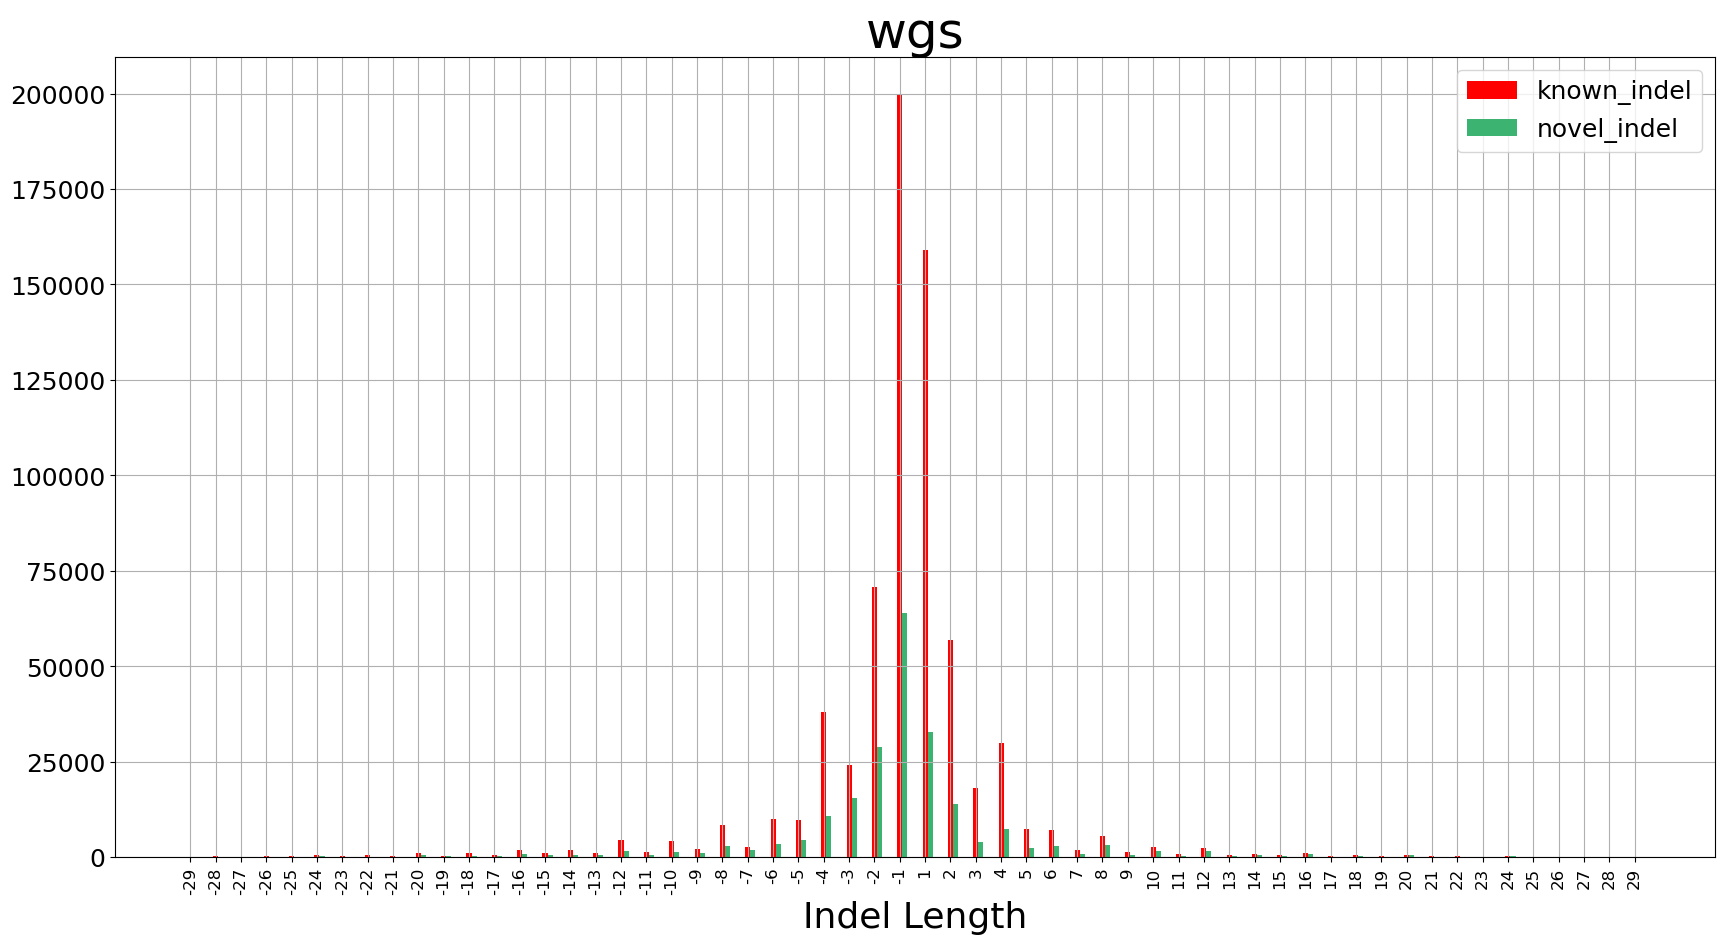

In [35]:
def ins_del_hete_graph_annot(xticks, known_indel,novel_indel, title=None):
    X = np.arange(known_indel.shape[0])
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(X + 0.00, known_indel, color = 'r', width = 0.20)
    ax.bar(X + 0.20, novel_indel, color = 'mediumseagreen', width = 0.20)

    ax.set_title(title)
    ax.set_xticks(np.arange(0,known_indel.shape[0]))
    ax.set_xticklabels(xticks,rotation=90, fontsize=12)
    ax.legend(labels=['known_indel', 'novel_indel'])
    ax.set_xlabel('Indel Length')
    
    

def ins_del_hete_graph(no_gt_statistics_wgs):
    
    #for no_gt_statistics,no_gt_statistics,annotation_name in zip(no_gt_statistics_files,no_gt_statistics_files,annotation_intervals_names):
    
    
    full_index = pd.Index(list(range(-60, 0)) + list(range(1, 60+1)), name='[3]length (deletions negative)')
    default_values = {
        '# IDD': 'IDD',
        '[2]id': 0,
        '[4]number of sites': 0,
        '[5]number of genotypes': 0,
        '[6]mean VAF': '.'
    }
    
    known_indel = pd.read_hdf(no_gt_statistics_wgs, '/idd_known')
    known_indel['[3]length (deletions negative)'] = known_indel['[3]length (deletions negative)'].astype(int)
    known_indel = known_indel.set_index('[3]length (deletions negative)').reindex(full_index).reset_index()
    known_indel.fillna(default_values, inplace=True)
    
    novel_indel = pd.read_hdf(no_gt_statistics_wgs, '/idd_novel')
    novel_indel['[3]length (deletions negative)'] = novel_indel['[3]length (deletions negative)'].astype(int)
    novel_indel = novel_indel.set_index('[3]length (deletions negative)').reindex(full_index).reset_index()
    novel_indel.fillna(default_values, inplace=True)
    
    known_indel = known_indel.loc[(known_indel['[3]length (deletions negative)']<30)&(known_indel['[3]length (deletions negative)']>-30)]
    novel_indel = novel_indel.loc[(novel_indel['[3]length (deletions negative)']<30)&(novel_indel['[3]length (deletions negative)']>-30)]

    ins_del_hete_graph_annot(novel_indel['[3]length (deletions negative)'].astype(int),
                             known_indel['[4]number of sites'].astype(int),
                             novel_indel['[4]number of sites'].astype(int),
               
               title='wgs')
        
ins_del_hete_graph(no_gt_statistics_wgs)

## Insertion Deletion Statistics for h-mer indels
Number of 1-base insretion deletions in hmer of each length

## Heterozygous

In [11]:
def ins_del_hete_graph(ins_del, ax, title):
    X = np.arange(12)
    
    ax.bar(X + 0.00, ins_del.iloc[0], color = 'r', width = 0.3)
    ax.bar(X + 0.3, ins_del.iloc[1], color = 'mediumseagreen', width = 0.3)
    ax.bar(X + 0.00, -ins_del.iloc[2], color = 'purple', width = 0.3)
    ax.bar(X + 0.3, -ins_del.iloc[3], color = 'g', width = 0.3)

    ax.set_title(title, fontsize=18)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(pd.Series(np.arange(1,13)).apply(lambda x: f"hmer {x}"),rotation=45)
    ax.legend(labels=['ins A', 'ins G', 'del A', 'del G'])
    ax.set_yticks(ax.get_yticks())
    
    ax.set_yticklabels([abs(x).astype(int) for x in ax.get_yticks()])
    ax.set_ylabel("Deletion        /       Insertion",

               loc="center")

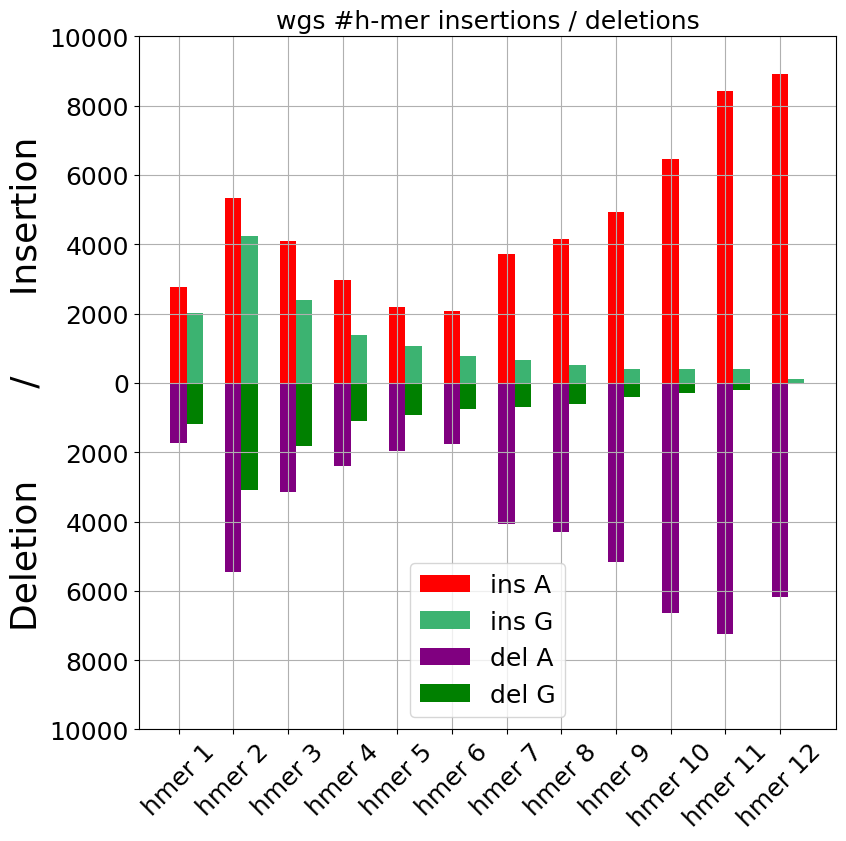

In [12]:
annotation_name = 'wgs'
ins_del_hete = pd.read_hdf(no_gt_statistics_wgs,'ins_del_hete')
ins_del_hete.columns = pd.Series(ins_del_hete.columns).apply(lambda x: f"h-mer {x}")

fig, ax = plt.subplots(figsize=(9, 9))
ins_del_hete_graph(ins_del_hete, ax, f'{annotation_name} #h-mer insertions / deletions')

## Homozygous

In [28]:
ins_del_homo = pd.read_hdf(no_gt_statistics_wgs,'ins_del_homo')
ins_del_homo.columns = pd.Series(ins_del_homo.columns).apply(lambda x: f"h-mer {x}")
fig, ax = plt.subplots(figsize=(9, 9))
ins_del_hete_graph(ins_del_homo, ax, f'wgs # insertions / deletions')

KeyError: 'No object named ins_del_homo in the file'